In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


def performance(score, prediction, label_test):
    """Draw the P-R curve and ROC
    https://www.youtube.com/watch?v=PQJ21XQWi08&t=302s
    """
    accuracy = accuracy_score(label_test, prediction)
    tn, fp, fn, tp = confusion_matrix(label_test, prediction).ravel()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2/ (1/ precision+ 1/ recall))

    FPR, TPR, thresholds = roc_curve(label_test, score)
    AUC = auc(FPR, TPR)

    precision, recall, thresholds = precision_recall_curve(label_test, score)

    plt.rcParams['figure.figsize'] = [14, 4]
    plt.subplot(1, 2, 1)
    plt.title = ("Precision-Recall Curve")
    plt.plot(recall, precision, 'b', label='AP = %0.2f' % precision.mean())
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc='lower right')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])

    plt.subplot(1, 2, 2)
    plt.title = ("ROC Curve")
    plt.plot(FPR, TPR, 'b', label='AUC = %0.2f' % AUC)
    plt.plot([0, 1], [0, 1], 'r-')
    plt.xlabel('True Positive Rate')
    plt.ylabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])


    print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))
    print('recall = ', recall.mean())
    print('Precision = ', precision.mean())
    print('f1_score = ', f1_score)
    return accuracy, recall.mean(), precision.mean(), f1_score

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# A labelled training set with full feature values
training_path1 = 'Data/sunny-or-not-sunny/training.csv'

# An additional labelled training set with missing feature values
training_path2 = 'Data/sunny-or-not-sunny/additional_training.csv'

confidence_path = 'Data/sunny-or-not-sunny/annotation_confidence.csv'

def load_data(Path):
    """using this method to read a csv file"""
    return pd.read_csv(Path)

# Connected with above traning set.
data = pd.concat([load_data(training_path1),load_data(training_path2)])
# data = load_data(training_path2)
# data = load_data(training_path2)

# # Imputation method for categorical columns:
# data = data.fillna(method='bfill', axis=0).fillna(0)

# # Impute none value with Mean value
# data = data.replace(np.NaN, data.mean())

# Delete the annotation confidence which equals 0.66
annotation_confidence = load_data(confidence_path)
annotation_confidence = annotation_confidence.values[:,1]
data.insert(loc=4609, column='confidence', value=annotation_confidence)
data=data[~data['confidence'].isin([0.66])]
data = data.drop('confidence',axis=1)

# CNN features
cols1 = [x for x in range(0,4097)]
cols1.append(4609)
data1 = data.iloc[:, cols1]

# GIST features
cols2 = [x for x in range(4097,4610)]
cols2.insert(0, 0)
data2 = data.iloc[:, cols2]

## Find the missing data_rate
# missing_data = data.isnull().sum()
# total_cells = np.product(data.shape)
# total_missing = missing_data.sum()

# print((total_missing/total_cells) * 100,"%")

# imp = IterativeImputer(max_iter=10, random_state=0)
# imp.fit(data1)

# IterativeImputer(random_state=0)
# np.round(imp.transform(data2))

In [3]:
# Split the data with test and training set
train_set, test_set = train_test_split(data1, test_size=0.2, random_state=23) # train:test = 8:2
# train_set, test_set = train_test_split(data1, test_size=0.2, random_state=23) # train:test = 8:2
# train_set, test_set = train_test_split(data2, test_size=0.2, random_state=23) # train:test = 8:2

feature_train = train_set.drop("prediction", axis=1)
label_train = train_set["prediction"].values

feature_test = test_set.drop("prediction", axis=1)
label_test = test_set["prediction"].values

In [4]:
# Apply normalization operation for numerical stability
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(feature_train)
feature_train = pd.DataFrame(scaler.transform(feature_train), columns=feature_train.columns)

# Imputer the missing value by KNN imputer which is better for other methods
imputer = KNNImputer(n_neighbors=2)
feature_train = imputer.fit_transform(feature_train)

scaler.fit(feature_test)
feature_test = pd.DataFrame(scaler.transform(feature_test), columns=feature_test.columns)
feature_test = imputer.fit_transform(feature_test)

In [5]:
# Apply the PCA which can anlysis the main features
from sklearn.decomposition import PCA
pca = PCA(n_components = 512)
pca.fit(feature_train) #fit PCA with training data instead of the whole dataset
feature_train = pca.transform(feature_train)
feature_test = pca.transform(feature_test)
print("PCA completed with 512 components")
print ("training data shape after PCA:",feature_train.shape)
print ("testing data shape after PCA:",feature_test.shape)

PCA completed with 512 components
training data shape after PCA: (816, 512)
testing data shape after PCA: (204, 512)


In [6]:
Methods = ['LogisticRegression','RandomForest','SVM']
Metrics = ['Accuracy','Recall','Precision','Fscore']

compare_df = pd.DataFrame(index = Methods, columns = Metrics)

In [7]:
from sklearn.model_selection import GridSearchCV
# Training se
param_grid = {"C":np.logspace(-10,10,10), "penalty":["l1","l2"],
              'solver': ['lbfgs', 'newton-cg', '‘sag’']}
  
grid_lr = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose=3)
  
# fitting the model for grid search
grid_lr_result = grid_lr.fit(feature_train, label_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ..............C=1e-10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 2/5] END ..............C=1e-10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 3/5] END ..............C=1e-10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 4/5] END ..............C=1e-10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 5/5] END ..............C=1e-10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 1/5] END ..........C=1e-10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV 2/5] END ..........C=1e-10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV 3/5] END ..........C=1e-10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV 4/5] END ..........C=1e-10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV 5/5] END ..........C=1e-10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV 1/5] END ..............C=1e-10, penalty=l1, solver=‘sag’; total time=   0.0s
[CV 2/5] END ..............C=1e-10, penalty=l1,

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/User

[CV 5/5] END C=1.6681005372000592e-08, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 1/5] END C=1.6681005372000592e-08, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 2/5] END C=1.6681005372000592e-08, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 3/5] END C=1.6681005372000592e-08, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 4/5] END C=1.6681005372000592e-08, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 5/5] END C=1.6681005372000592e-08, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 1/5] END C=2.782559402207126e-06, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 2/5] END C=2.782559402207126e-06, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 3/5] END C=2.782559402207126e-06, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 4/5] END C=2.782559402207126e-06, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 5/5] END C=2.782559402207126e-06, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 1/5] END C=2.782559402207126e-06, penalty=l1, solver=newton-cg; total tim

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

[CV 3/5] END C=0.0004641588833612782, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 4/5] END C=0.0004641588833612782, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 5/5] END C=0.0004641588833612782, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 1/5] END C=0.0004641588833612782, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 2/5] END C=0.0004641588833612782, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 3/5] END C=0.0004641588833612782, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 4/5] END C=0.0004641588833612782, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 5/5] END C=0.0004641588833612782, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 1/5] END C=0.0004641588833612782, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 2/5] END C=0.0004641588833612782, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 3/5] END C=0.0004641588833612782, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 4/5] END C=0.0004641588833612782, penalty=l2, solver=‘sag’; tot

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

[CV 1/5] END C=0.07742636826811278, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 2/5] END C=0.07742636826811278, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 3/5] END C=0.07742636826811278, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 4/5] END C=0.07742636826811278, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 5/5] END C=0.07742636826811278, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 1/5] END C=0.07742636826811278, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 2/5] END C=0.07742636826811278, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 3/5] END C=0.07742636826811278, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 4/5] END C=0.07742636826811278, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 5/5] END C=0.07742636826811278, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 1/5] END .C=12.915496650148826, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 2/5] END .C=12.915496650148826, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 3/5]

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

[CV 2/5] END C=12.915496650148826, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 3/5] END C=12.915496650148826, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 4/5] END C=12.915496650148826, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 5/5] END C=12.915496650148826, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 1/5] END .C=12.915496650148826, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 2/5] END .C=12.915496650148826, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 3/5] END .C=12.915496650148826, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 4/5] END .C=12.915496650148826, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 5/5] END .C=12.915496650148826, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 1/5] END .C=2154.4346900318865, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 2/5] END .C=2154.4346900318865, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 3/5] END .C=2154.4346900318865, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 4/5] END .C=

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

[CV 1/5] END .C=2154.4346900318865, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 2/5] END .C=2154.4346900318865, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 3/5] END .C=2154.4346900318865, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 4/5] END .C=2154.4346900318865, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 5/5] END .C=2154.4346900318865, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 1/5] END C=2154.4346900318865, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 2/5] END C=2154.4346900318865, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 3/5] END C=2154.4346900318865, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 4/5] END C=2154.4346900318865, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 5/5] END C=2154.4346900318865, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 1/5] END .C=2154.4346900318865, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 2/5] END .C=2154.4346900318865, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 3/5] END 

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

[CV 2/5] END .C=359381.36638046405, penalty=l1, solver=‘sag’; total time=   0.0s
[CV 3/5] END .C=359381.36638046405, penalty=l1, solver=‘sag’; total time=   0.0s
[CV 4/5] END .C=359381.36638046405, penalty=l1, solver=‘sag’; total time=   0.0s
[CV 5/5] END .C=359381.36638046405, penalty=l1, solver=‘sag’; total time=   0.0s
[CV 1/5] END .C=359381.36638046405, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 2/5] END .C=359381.36638046405, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 3/5] END .C=359381.36638046405, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 4/5] END .C=359381.36638046405, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 5/5] END .C=359381.36638046405, penalty=l2, solver=lbfgs; total time=   0.0s
[CV 1/5] END C=359381.36638046405, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 2/5] END C=359381.36638046405, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 3/5] END C=359381.36638046405, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 4/5] END C=3593

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

[CV 5/5] END C=59948425.03189421, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 1/5] END ..C=59948425.03189421, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 2/5] END ..C=59948425.03189421, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 3/5] END ..C=59948425.03189421, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 4/5] END ..C=59948425.03189421, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 5/5] END ..C=59948425.03189421, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 1/5] END ......C=10000000000.0, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 2/5] END ......C=10000000000.0, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 3/5] END ......C=10000000000.0, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 4/5] END ......C=10000000000.0, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 5/5] END ......C=10000000000.0, penalty=l1, solver=lbfgs; total time=   0.0s
[CV 1/5] END ..C=10000000000.0, penalty=l1, solver=newton-cg; total time=   0.0s
[CV 2/5] END ..C=100000000

/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

[CV 4/5] END ..C=10000000000.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV 5/5] END ..C=10000000000.0, penalty=l2, solver=newton-cg; total time=   0.1s
[CV 1/5] END ......C=10000000000.0, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 2/5] END ......C=10000000000.0, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 3/5] END ......C=10000000000.0, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 4/5] END ......C=10000000000.0, penalty=l2, solver=‘sag’; total time=   0.0s
[CV 5/5] END ......C=10000000000.0, penalty=l2, solver=‘sag’; total time=   0.0s


/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhusenlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got ‘sag’.

  warnings.warn("Estimator fit fa

Best: 0.826029 using {'C': 0.0004641588833612782, 'penalty': 'l2', 'solver': 'lbfgs'}
nan  with:   {'C': 1e-10, 'penalty': 'l1', 'solver': 'lbfgs'}
nan  with:   {'C': 1e-10, 'penalty': 'l1', 'solver': 'newton-cg'}
nan  with:   {'C': 1e-10, 'penalty': 'l1', 'solver': '‘sag’'}
0.564948  with:   {'C': 1e-10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.564948  with:   {'C': 1e-10, 'penalty': 'l2', 'solver': 'newton-cg'}
nan  with:   {'C': 1e-10, 'penalty': 'l2', 'solver': '‘sag’'}
nan  with:   {'C': 1.6681005372000592e-08, 'penalty': 'l1', 'solver': 'lbfgs'}
nan  with:   {'C': 1.6681005372000592e-08, 'penalty': 'l1', 'solver': 'newton-cg'}
nan  with:   {'C': 1.6681005372000592e-08, 'penalty': 'l1', 'solver': '‘sag’'}
0.564948  with:   {'C': 1.6681005372000592e-08, 'penalty': 'l2', 'solver': 'lbfgs'}
0.564948  with:   {'C': 1.6681005372000592e-08, 'penalty': 'l2', 'solver': 'newton-cg'}
nan  with:   {'C': 1.6681005372000592e-08, 'penalty': 'l2', 'solver': '‘sag’'}
nan  with:   {'C': 2.78255940220

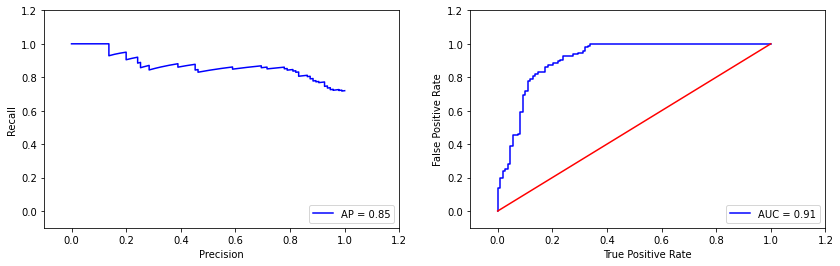

In [8]:
print("Best: %f using %s" % (grid_lr_result.best_score_,grid_lr.best_params_))
#grid_scores_：The evaluation results under different parameters are given.
#best_ params_： Describes the combination of parameters that have achieved the best results。
#best_score_：Members provide the best ratings observed during the optimization process
#Dict with key as column title and value as column can be imported into dataframe.
#Note that the "params" key is used to store a list of parameter settings for all parameter candidates.
means = grid_lr_result.cv_results_['mean_test_score']
params = grid_lr_result.cv_results_['params']

for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

#View cross validation results
print("best parameters mode：\n", grid_lr.best_estimator_)
print('best score：\n',grid_lr.best_score_)

# #Calculation accuracy
# score=grid_lr.score(feature_test,label_test)
# print('Calculation accuracy\n',score)

# https://blog.csdn.net/weixin_43297167/article/details/105269963
#https://blog.csdn.net/lixiaowang_327/article/details/53434744

# Apply the trained model to train new test data set
prediction_lg = grid_lr.predict(feature_test)
score_lg = grid_lr.predict_proba(feature_test)[:,1]

# Draw PR-curve and ROC-curve
performance1 = performance(score_lg, prediction_lg, label_test)
 
# Put the scores into Dataframe to compared
compare_df.loc['LogisticRegression'] = performance1

print(compare_df)

Best: 0.701163 using {'criterion': 'entropy', 'min_samples_leaf': 6, 'n_estimators': 20}
0.581126  with:   {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 10}
0.633859  with:   {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 15}
0.622916  with:   {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 20}
0.620064  with:   {'criterion': 'gini', 'min_samples_leaf': 4, 'n_estimators': 10}
0.626083  with:   {'criterion': 'gini', 'min_samples_leaf': 4, 'n_estimators': 15}
0.622825  with:   {'criterion': 'gini', 'min_samples_leaf': 4, 'n_estimators': 20}
0.651583  with:   {'criterion': 'gini', 'min_samples_leaf': 6, 'n_estimators': 10}
0.669258  with:   {'criterion': 'gini', 'min_samples_leaf': 6, 'n_estimators': 15}
0.686061  with:   {'criterion': 'gini', 'min_samples_leaf': 6, 'n_estimators': 20}
0.626364  with:   {'criterion': 'entropy', 'min_samples_leaf': 2, 'n_estimators': 10}
0.671948  with:   {'criterion': 'entropy', 'min_samples_leaf': 2, 'n_estimator

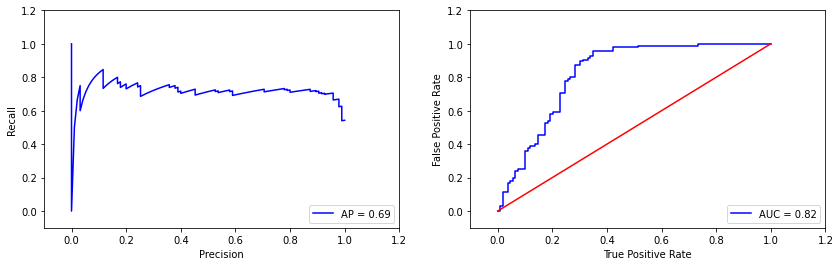

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Training grid to search the best parameters for RandomForest
param_grid = { "n_estimators": [10, 15, 20],
                "criterion": ["gini", "entropy"],
                "min_samples_leaf": [2, 4, 6]}
  
grid_rd = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1',verbose=0)

# fitting the model for grid search
grid_rd_result = grid_rd.fit(feature_train, label_train)

print("Best: %f using %s" % (grid_rd_result.best_score_,grid_rd.best_params_))
#grid_scores_：The evaluation results under different parameters are given.
#best_ params_： Describes the combination of parameters that have achieved the best results。
#best_score_：Members provide the best ratings observed during the optimization process
#Dict with key as column title and value as column can be imported into dataframe.
#Note that the "params" key is used to store a list of parameter settings for all parameter candidates.
means = grid_rd_result.cv_results_['mean_test_score']
params = grid_rd_result.cv_results_['params']

for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

#View cross validation results
print("best parameters mode：\n", grid_rd.best_estimator_)
print('best score：\n',grid_rd.best_score_)

# #Compare with the real value
# y_predict=estimator.predict(x_test)
# print('Comparison between real value and predicted value：',y_predict==y_test)

# #Calculation accuracy
# score=grid_lr.score(feature_test,label_test)
# print('Calculation accuracy\n',score)

# https://blog.csdn.net/weixin_43297167/article/details/105269963
#https://blog.csdn.net/lixiaowang_327/article/details/53434744

# Apply the trained model to train new test data set
prediction_rd = grid_rd.predict(feature_test)
score_rd = grid_rd.predict_proba(feature_test)[:,1]

# Draw PR-curve and ROC-curve
performance2 = performance(score_rd, prediction_rd, label_test)
 
# Put the scores into Dataframe to compared
compare_df.loc['RandomForest'] = performance2
print(compare_df)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid']} 
  
grid_svm = GridSearchCV(SVC(probability=True), param_grid, refit = True, cv=5, scoring='f1',verbose=3)
  
# fitting the model for grid search
grid_svm_result = grid_svm.fit(feature_train, label_train)

print("Best: %f using %s" % (grid_svm_result.best_score_,grid_svm.best_params_))
#grid_scores_：The evaluation results under different parameters are given.
#best_ params_： Describes the combination of parameters that have achieved the best results。
#best_score_：Members provide the best ratings observed during the optimization process
#Dict with key as column title and value as column can be imported into dataframe.
#Note that the "params" key is used to store a list of parameter settings for all parameter candidates.
means = grid_svm_result.cv_results_['mean_test_score']
params = grid_svm_result.cv_results_['params']

for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

#View cross validation results
print("best parameters mode：\n", grid_svm.best_estimator_)
print('best score：\n',grid_svm.best_score_)

# #Calculation accuracy
# score=grid_svm.score(feature_test,label_test)
# print('Calculation accuracy\n',score)

# https://blog.csdn.net/weixin_43297167/article/details/105269963
#https://blog.csdn.net/lixiaowang_327/article/details/53434744

prediction_svm = grid_svm.predict(feature_test) # predict the target of testing samples 
score = grid_svm.predict_proba(feature_test)[:,1]

performance3 = performance(score, prediction_svm, label_test)
compare_df.loc['SVM'] = performance3

print(compare_df)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.3s
[CV 2/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.3s
[CV 3/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.3s
[CV 4/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.3s
[CV 5/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.3s
[CV 1/5] END ...............C=0.001, gamma=1, kernel=sigmoid; total time=   0.2s
[CV 2/5] END ...............C=0.001, gamma=1, kernel=sigmoid; total time=   0.2s
[CV 3/5] END ...............C=0.001, gamma=1, kernel=sigmoid; total time=   0.2s
[CV 4/5] END ...............C=0.001, gamma=1, kernel=sigmoid; total time=   0.2s
[CV 5/5] END ...............C=0.001, gamma=1, kernel=sigmoid; total time=   0.3s
[CV 1/5] END .................C=0.001, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 2/5] END .................C=0.001, gamma=0.

[CV 2/5] END .......................C=1, gamma=1, kernel=rbf; total time=   0.3s
[CV 3/5] END .......................C=1, gamma=1, kernel=rbf; total time=   0.3s
[CV 4/5] END .......................C=1, gamma=1, kernel=rbf; total time=   0.3s
[CV 5/5] END .......................C=1, gamma=1, kernel=rbf; total time=   0.3s
[CV 1/5] END ...................C=1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 2/5] END ...................C=1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 3/5] END ...................C=1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 4/5] END ...................C=1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 5/5] END ...................C=1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 1/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 2/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 3/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 4/5] END ...............

[CV 4/5] END .....................C=100, gamma=1, kernel=rbf; total time=   0.4s
[CV 5/5] END .....................C=100, gamma=1, kernel=rbf; total time=   0.3s
[CV 1/5] END .................C=100, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 2/5] END .................C=100, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 3/5] END .................C=100, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 4/5] END .................C=100, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 5/5] END .................C=100, gamma=1, kernel=sigmoid; total time=   0.1s
[CV 1/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 2/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 3/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 4/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 5/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.4s
[CV 1/5] END ...............

In [ ]:
# Predict the test.csv

test_path = 'Data/sunny-or-not-sunny/testing.csv'

test_data = load_data(test_path)

# Save CNN features
cols_test = [x for x in range(0,4097)]
test_data = test_data.iloc[:, cols_test]

# Data preProcessing
scaler.fit(test_data)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# PCA
pca=PCA(n_components = 2)
pca.fit(test_data)
test_data = pca.transform(test_data)

# apply the SVM model to test and output the results
test_Predict = grid_svm.predict(test_data)

a = []
b = [] 
for i in range(2818):
    a.append(i+1)
    b.append(test_Predict[i])

#The key value in the dictionary is the column name in CSV
dataframe = pd.DataFrame({'ID':a,'Prediction':b})
print(dataframe['Prediction'].value_counts())
print(dataframe)
 
#Store DataFrame as csv, index indicates whether row name is displayed, default=True
dataframe.to_csv("results.csv",index=False,sep=',')